<a href="https://colab.research.google.com/github/Arye182/Deep_Learning_Monet_Competition_Kaggle/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
The project is a part of a final assignment in course deep learning, as part of kaggle competition im I’m Something of a Painter Myself in which we can actually take photos from life and translate them into monet styled photos. Adding style to photos is a very popular issue in programming nowadays, we see a lot of filters and image processing applications on a daily basis. The ability to take photos and mimic the style of an artist is a quite impressive challenge.     

  
**References**  
  
    
      
notebooks:    
https://www.kaggle.com/amyjang/monet-cyclegan-tutorial - tuturial notebook  
https://www.kaggle.com/unfriendlyai/cyclegan-with-dg-pretraining - used the help to create fid




# Installations & Imports
here we will prepare everything

#### Installations

In [1]:
!pip install -q kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install tensorflow_addons
!pip install image-quality

     |████████████████████████████████| 58 kB 3.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=46a4aa5be76118033091a6ac6b24528e38ce4addad0817e9eeeeebd2a4aeb4e4
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 679 kB 5.0 MB/s 
     |████████████████████████████████| 146 kB 5.0 MB/s 
     |████████████████████████████████| 170 kB 8.8 MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp37-cp37m-linux_x86_64.whl size=233356 sha256=cc01b007e9b6f19b3912ecb41b050d5da265b92dad805dd18b0e763a71c7cfbf
  Stored in directory: /root/.cache/pip/wheels/cd/e8/1e/bf95cf256e4d3ffc94289ab508c49d48e34c98220af63e3513
Successfully built libsvm


#### Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from google.colab import files
import PIL
import shutil
from tensorflow.keras.callbacks import History
import imquality.brisque as brisque
import PIL.Image



import matplotlib.pyplot as plt
import numpy as np

#### TPU Initialization

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.5.0


# Data Base

#### Data Path And Filenames Preperations

In [4]:
GCS_PATH = 'gs://kds-fe07dc19ed486a7fdc7d0a06e0362b4db01fa035a6c107442b99a8f2'
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/monet*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/photo*.tfrec'))

In [5]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


#### Define Handling Images

In [6]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

#### Define Load Data Set Function

In [7]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

#### Load Data Sets For Model CycleGan


In [8]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

#### Load Data Sets For FID

In [9]:
fid_photo_ds = load_dataset(PHOTO_FILENAMES).take(1024).batch(32*strategy.num_replicas_in_sync).prefetch(32)
fid_monet_ds = load_dataset(MONET_FILENAMES).batch(32*strategy.num_replicas_in_sync).prefetch(32)

#### Showing A Taste Of The Data

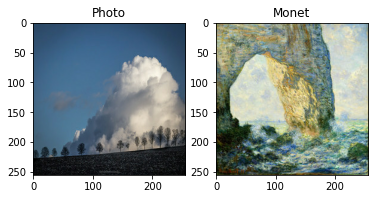

In [10]:
monet_ds_iter = iter(monet_ds)
photo_ds_iter = iter(photo_ds)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# CycleGan Model
need to understand what it is

#### Generator

In [11]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [12]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [13]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

#### Discriminator

In [14]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

#### Initialize Generators And Discriminators

In [15]:

with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

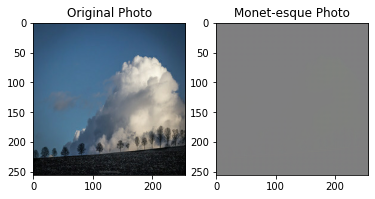

In [16]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

#### Define CycleGan Model

In [17]:
# Generate a CallBack function to save
# the prediction, for each epoch, of the Photo above 
class GANMonitor(keras.callbacks.Callback):
   """A callback to generate and save images after each epoch"""

   def on_epoch_end(self, epoch, logs=None):
       prediction = gen_monet(photo, training=False)[num_photo].numpy()
       prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
       im_to_gif[epoch] = prediction 

In [18]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

#### Loss

In [19]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [20]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [21]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [22]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

#### FID - Frechet Distance

In [23]:
with strategy.scope():

    inception_model = tf.keras.applications.InceptionV3(input_shape=(256,256,3),pooling="avg",include_top=False)

    mix3  = inception_model.get_layer("mixed9").output
    f0 = tf.keras.layers.GlobalAveragePooling2D()(mix3)

    inception_model = tf.keras.Model(inputs=inception_model.input, outputs=f0)
    inception_model.trainable = False

    def calculate_activation_statistics_mod(images,fid_model):

            act=tf.cast(fid_model.predict(images), tf.float32)

            mu = tf.reduce_mean(act, axis=0)
            mean_x = tf.reduce_mean(act, axis=0, keepdims=True)
            mx = tf.matmul(tf.transpose(mean_x), mean_x)
            vx = tf.matmul(tf.transpose(act), act)/tf.cast(tf.shape(act)[0], tf.float32)
            sigma = vx - mx
            return mu, sigma
    myFID_mu2, myFID_sigma2 = calculate_activation_statistics_mod(fid_monet_ds,inception_model)        
    fids=[]

87916544/87910968 [==============================] - 1s 0us/step


In [24]:
with strategy.scope():
    def calculate_frechet_distance(mu1,sigma1,mu2,sigma2):
        fid_epsilon = 1e-14
       
        covmean = tf.linalg.sqrtm(tf.cast(tf.matmul(sigma1,sigma2),tf.complex64))
#         isgood=tf.cast(tf.math.is_finite(covmean), tf.int32)
#         if tf.size(isgood)!=tf.math.reduce_sum(isgood):
#             return 0

        covmean = tf.cast(tf.math.real(covmean),tf.float32)
        tr_covmean = tf.linalg.trace(covmean)

        return tf.matmul(tf.expand_dims(mu1 - mu2, axis=0),tf.expand_dims(mu1 - mu2, axis=1)) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean

    def FID(images,gen_model,inception_model=inception_model,myFID_mu2=myFID_mu2, myFID_sigma2=myFID_sigma2):
                inp = layers.Input(shape=[256, 256, 3], name='input_image')
                x  = gen_model(inp)
                x=inception_model(x)
                fid_model = tf.keras.Model(inputs=inp, outputs=x)
                mu1, sigma1= calculate_activation_statistics_mod(images,fid_model)
                fid_value = calculate_frechet_distance(mu1, sigma1,myFID_mu2, myFID_sigma2)
                return fid_value

#### Optimizerrs

In [25]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Steps 1,2 - Base Line Model Evaluation



#### Define Model Evaluator With Results Presentation (will convert to Class)
Taking the mean might not be the good way, but we can still monitor something]

In [26]:
def evaluate_model(epochs, data, fid_flag):
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos
    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

    # define model
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    # compile model
    cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss)

    plotter = GANMonitor()

    hist = cycle_gan_model.fit(data, epochs=epochs, callbacks=[History()])


    if (fid_flag):
      fids=[]
      best_fid=999999999
      for epoch in range(1,epochs):
          print("Epoch = ",epoch)
          cycle_gan_model.fit(data, epochs=epochs, callbacks=[History()])
          # if epoch>35:
          cur_fid=FID(fid_photo_ds,monet_generator_30)
          fids.append(cur_fid)
          print("After epoch #{} FID = {}\n".format(epoch,cur_fid))
          # if epoch>42:
          #      best_fid=cur_fid
          #      monet_generator.save('monet_generator_'+str(epoch)+'.h5')
      plt.plot(np.array(fids).reshape(-1,), label='FID')
      plt.legend()
      plt.show()

    return hist

#### Define History to Loss Graph Creator

In [27]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot_smoothed_acc_and_loss(epochs, history, factor=0.8):
    monet_g = []
    photo_g = []
    monet_d = []
    photo_d = []

    for i in range(np.array(history.history["monet_gen_loss"]).shape[0]):
        monet_g.append(history.history["monet_gen_loss"][i].squeeze().mean())
        photo_g.append(history.history["photo_gen_loss"][i].squeeze().mean())
        monet_d.append(history.history["monet_disc_loss"][i].squeeze().mean())
        photo_d.append(history.history["photo_disc_loss"][i].squeeze().mean())

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(smooth_curve(monet_g, factor=factor),label="Monet")
    axs[0].plot(smooth_curve(photo_g, factor=factor),label="Photo")
    axs[0].set_title("Smoothed generator loss")
    axs[0].legend()

    axs[1].plot(smooth_curve(monet_d, factor=factor),label="Monet")
    axs[1].plot(smooth_curve(photo_d, factor=factor),label="Photo")
    axs[1].set_title("Smoothed discriminator loss")
    axs[1].legend()

    plt.show()

#### Parameters

In [28]:
EPOCHS = 25


#### BaseLineModel - 300 Monets

In [ ]:
%%time
with strategy.scope():
    data_set = tf.data.Dataset.zip((monet_ds, photo_ds))
    history = evaluate_model(EPOCHS, data_set, False)

In [ ]:
plot_smoothed_acc_and_loss(EPOCHS, history, 0.8 )

#### BaseLineModel - 30 Monets

In [ ]:
%%time

with strategy.scope():
    data_set = tf.data.Dataset.zip((monet_ds.take(30), photo_ds))
    history = evaluate_model(EPOCHS, data_set, False)

In [ ]:
plot_smoothed_acc_and_loss(EPOCHS, history, 0.8 )

# Step 2.5 - Choosing The Right 30 Images

#### Grading The Monet Photos With Library Image-Quality

In [ ]:
dict = {}
for i, image in enumerate(monet_ds):
    # image = decode_image(image)
    score =  brisque.score(image[0])
    print(i , " scor : " ,score)
    dict[i] = score
print(dict)
sorted(dict.items(), key=lambda item: item[1])
print(dict)
dict_sorted = sorted((value,key) for (key,value) in dict.items())
print()
print(dict_sorted)
print()
#best 100 images:
print()
for i in range (1,100):
    print(dict_sorted[i])

#### Taking The Most 1000 Best Photos

In [ ]:
# print(dict)
# print(dict_sorted)
list = []
for i in range(0,100):
    list.append(dict_sorted[i][1])

i = 0
for  i, image in enumerate(monet_ds):
    # print(dict_sorted[i][1], i)
    if i in list:
        print("mathc")
        img = image[0].numpy()
        img = (img * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(img)
        im.save("/content/best/" + str(i) + ".jpg")

    i += 1



#### Histograming Colors So We Can Choose 30 out of 100

# Step 3 -  Augmentation Model Check

In [33]:
while True: pass

KeyboardInterrupt: ignored

#### Example Of Our Results - save for the last model? or impleent as every one

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Save TensorFlow Model (H5)
The Best Model With The Best Images After it has been trained

In [ ]:
monet_generator.save('/content/monet_generator.h5')
photo_generator.save('/content/photo_generator.h5')
monet_discriminator.save('/content/monet_discriminator.h5')
photo_discriminator.save('/content/photo_discriminator.h5')